In [2]:
%matplotlib inline

# Assignment 5

**DUE: Sunday December 5, 2021 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [3]:
NAME = "Sanjay Shrikanth"
STUDENT_ID = "1718751"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential

## Question 1: Bitcoin Price Prediction
---
Bitcoin, amongst other assets like AMC and GME, has been all the rage this past year and reached an all time high of \$68,521 per bitcoin. Since reaching it's high, the price has dropped by nearly a half. Analysts continue to feed the frenzy by releasing price predictions that range from from \$500,000 to \$9,000 per bitcoin in the next year. You will make an Recurrent neural network model to gain some insight into price prediction. Yahoo! Finance is a trusted name in free financial information and has been with us since the internet's early years. You'll be using data gathered obtained from https://finance.yahoo.com/quote/BTC-USD/history/ to train your recurrent neural network.

Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

Link to the raw data: [link](https://drive.google.com/file/d/1IvrXXUDB_kO4ydZb-lwtVF9BLccDtdJP/view?usp=sharing)

In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1IvrXXUDB_kO4ydZb-lwtVF9BLccDtdJP'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')


In [6]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [7]:
# Plot data.head()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Let's plot the bitcoin price. First, we will make a plot of bitcoin price vs the days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

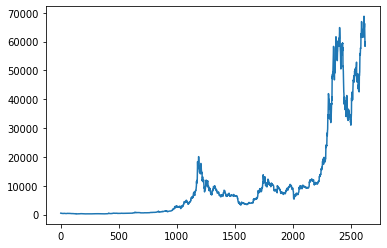

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))


Next, we plot bitcoin vs. days. But this time there are dates added to the graph.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

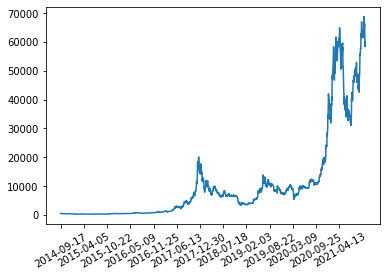

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))
#g.map(plt.plot, "a", "v", marker="o")
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### Part a) Data Preprocessing (5 points)
In this section you will preprocess the in order to train a recurrent neural network. We can see that there 5 columns, "Date", "Open", "High", "Low", "Close", "Adjusted Close", and "Volume". We will only use the High column.

In [10]:
# Create a dataframe that only contains High Column.
# Hint: it may be helpful to now cast your pruned dataframe to a numpy array.
data = data.dropna(subset=["High"])
data_high = data["High"].to_numpy()


Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. Use it to scale the data for our analysis. 

In [11]:
### YOUR CODE HERE ###
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data_normalized = scaler.fit_transform(data_high.reshape(-1,1)).flatten()

You will implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, we will simply augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction. The function to augment the data is given to you:

In [12]:

def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [13]:
# Choose the number of time steps that the model "looks back"
time_steps = 50

# Produce your dataset based on the number of days the model could look back
X,y = create_dataset(data_normalized, time_steps)

In [14]:
# Check the shape of your dataset
print(X.shape, y.shape)

(2567, 50) (2567,)


### Part b) Data Partitioning (5 points)
Split data into train and test sets. Use 80\% for training and 20\% for testing. **Note**: you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(X_train.shape)

(2053, 50)


For this dataset, you need to reshape the partitions for the model to be able to process them.

In [16]:
# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Part c) RNN Model (15 points)
In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss. Use mean squared error as your model's metric.

Compile your model and display the summary:

In [17]:
# Build your model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, BatchNormalization, GRU

input = Input(shape=(1,time_steps))
x = LSTM(128)(input)
x = Dense(1)(x)
model = Model(input, x)

model.summary()

loss = tf.keras.losses.MeanSquaredError()

opt = tf.keras.optimizers.Adam(0.001)

metrics = tf.keras.metrics.MeanSquaredError()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 50)]           0         
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 91,777
Trainable params: 91,777
Non-trainable params: 0
_________________________________________________________________


In [18]:
batchsize = 120

epochs =  15

# Fit model
model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=False)

Epoch 1/15
14/14 [==============================] - 6s 52ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 8.4927e-04 - val_mean_squared_error: 8.4927e-04
Epoch 2/15
14/14 [==============================] - 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 6.6424e-04 - val_mean_squared_error: 6.6424e-04
Epoch 3/15
14/14 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/15
14/14 [==============================] - 0s 8ms/step - loss: 9.9929e-04 - mean_squared_error: 9.9929e-04 - val_loss: 6.4590e-04 - val_mean_squared_error: 6.4590e-04
Epoch 5/15
14/14 [==============================] - 0s 7ms/step - loss: 5.4790e-04 - mean_squared_error: 5.4790e-04 - val_loss: 6.8344e-04 - val_mean_squared_error: 6.8344e-04
Epoch 6/15
14/14 [==============================] - 0s 8ms/step - loss: 3.4776e-04 - mean_squared_error: 3.4776e-04 - val_loss: 3.9982e-04 - val_mean_s

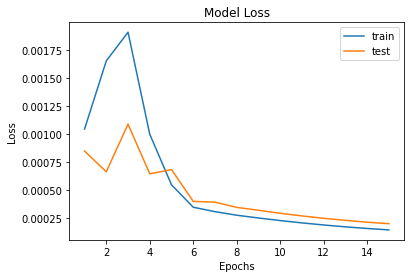

In [19]:
# Plot the Model loss

plt.plot([x+1 for x in range(epochs)], history.history['loss'])
plt.plot([x+1 for x in range(epochs)], history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss. Again, use mean squared error as your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [20]:
# Build your model
input = Input(shape=(1,time_steps))
x = GRU(128)(input)
x = Dense(200, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1)(x)
model = Model(input, x)

model.summary()

loss = tf.keras.losses.MeanSquaredError()

opt = tf.keras.optimizers.Adam(2e-4)

metrics = tf.keras.metrics.MeanSquaredError()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 50)]           0         
                                                                 
 gru (GRU)                   (None, 128)               69120     
                                                                 
 dense_1 (Dense)             (None, 200)               25800     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 95,121
Trainable params: 95,121
Non-trainable params: 0
_________________________________________________________________


In [21]:
batchsize = 200

epochs =  30

# Fit model
model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=False)

Epoch 1/30
9/9 [==============================] - 3s 73ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 2/30
9/9 [==============================] - 0s 8ms/step - loss: 7.7983e-04 - mean_squared_error: 7.7983e-04 - val_loss: 5.3655e-04 - val_mean_squared_error: 5.3655e-04
Epoch 3/30
9/9 [==============================] - 0s 9ms/step - loss: 7.1721e-04 - mean_squared_error: 7.1721e-04 - val_loss: 3.9155e-04 - val_mean_squared_error: 3.9155e-04
Epoch 4/30
9/9 [==============================] - 0s 12ms/step - loss: 4.6698e-04 - mean_squared_error: 4.6698e-04 - val_loss: 3.1973e-04 - val_mean_squared_error: 3.1973e-04
Epoch 5/30
9/9 [==============================] - 0s 8ms/step - loss: 3.2713e-04 - mean_squared_error: 3.2713e-04 - val_loss: 3.4658e-04 - val_mean_squared_error: 3.4658e-04
Epoch 6/30
9/9 [==============================] - 0s 8ms/step - loss: 3.5787e-04 - mean_squared_error: 3.5787e-04 - val_loss: 2.9516e-04 - val_m

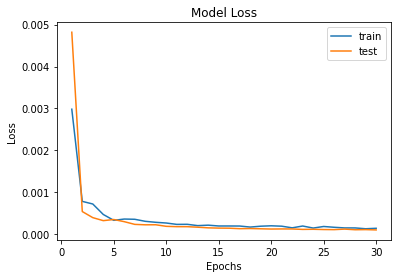

In [22]:
# Plot the Model loss

plt.plot([x+1 for x in range(epochs)], history.history['loss'])
plt.plot([x+1 for x in range(epochs)], history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Part e) Looking at the Predictions (10 points)
Now, Using the final (best) model you trained, show your model's performance on the test set. Plot the model's prediction for Bitcoin Price along with the actual test set prices. Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help? Does your model use dropout or batchnormalization?

**Note:** Your model is trained on normalized data. Inorder to transform your model's predictions to the original price range you will likely need to use sklearn's inverse_transform (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

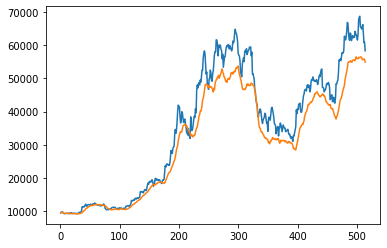

In [23]:
test_size = len(X_test)
predict_bitcoin = model.predict(X_test)
predict_bitcoin = scaler.inverse_transform(predict_bitcoin)
old_y = scaler.inverse_transform(y_test.reshape(-1,1))
sns.lineplot(x = np.linspace(1,test_size,test_size), y = old_y.reshape(-1))
sns.lineplot(x = np.linspace(1,test_size,test_size), y = predict_bitcoin.flatten())

For this model, as the number of days "looked back" increases, the more the RNN prediction seem to match the trend of the test set. With looking back lower time steps, the less the prediction curve followed the fluctuations of the test curve, meaning that perhaps the model generalizes too much when looking too close on recent data. Since looking back farther allows the model to understand the growth trend of the bitcoin prices, it is able to make more accurate predictions for future prices. It appears that adding more layers does improve the validation mean-squared error values, but only a few additions with tweaked values outputted the best result. Changing the parameters of the ```Dense``` layers, learning rate, dropout rate, and the type of memory cell used were the main determining factors.  My model uses ```Dropout``` layers to improve the model's ability to learn the parameters but not ```BatchNormalization``` layers. 

## Question 2: Reuters Topic Classification
---
We will use the [Reuters newswire](https://keras.io/api/datasets/reuters/) classification dataset, which has text paired with 46 topics as labels. You can see what these labels represent [here](https://martin-thoma.com/nlp-reuters/). You will analyze the text and classify the text into one of the 46 classes. Classes are the defined based on the following list (in the same order):
>```
['cocoa','grain','veg-oil','earn','acq','wheat','copper',
'housing','money-supply','coffee','sugar','trade','reserves',
'ship','cotton','carcass','crude','nat-gas','cpi','money-fx',
'interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel',
'rubber','heat','jobs','lei','bop','zinc','orange',
'pet-chem','dlr','gas','silver','wpi','hog','lead']
```



### Part a) Processing the Data (5 points)
Load the data simply from Keras: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data.
You also need to follow the RNN handout from the class exercise and prepare encoding and decoding functions and any other pre-processing you might find useful.

Print 5 examples of news along with their class label. 

In [24]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

import textwrap
# Load data
max_seq = 1500
(X, y), (_, _) = reuters.load_data(test_split=0, maxlen=max_seq) ## we want to split it later

# Clean and pre-process the data
word_dict = reuters.get_word_index()
word_dict = {k:(v+3) for k,v in word_dict.items()}
word_dict["<PAD>"] = 0
word_dict["<START>"] = 1
word_dict["<UNK>"] = 2
word_dict["<UNUSED>"] = 3

vocab_len = len(word_dict)
inverse_word_dict = {v:k for k,v in word_dict.items()}
X = pad_sequences(X, maxlen=max_seq)

def encode_text(news, word_dict, maxlen):
  text = []
  for raw in news.split(' '):
    word = raw.strip().strip(string.punctuation).lower()
    if word is '' or word is '\n':
      continue
    try:
      text.append(word_dict[word])
    except KeyError as e:
      # raise KeyError(f'{e} not in word dictionary, review not encoded.')
      continue
  return pad_sequences(np.array(text).reshape(1,-1), maxlen=maxlen)

def decode_text(encoded_news, inverse_word_dict):
  sentence = []
  for encoded_word in encoded_news:
    if encoded_word == 0:
      continue
    sentence.append(inverse_word_dict[encoded_word])
  
  w = textwrap.TextWrapper(width=120,break_long_words=False,replace_whitespace=False)
  return '\n'.join(w.wrap(' '.join(sentence)))

# Print sample data
indexes = [3,70,127,488, 600] # arbitrary sample indicies
for i in indexes:
  print(f"News: {decode_text(X[i], inverse_word_dict)}")
  print(f"Label: {y[i]} \n\n")

565248/550378 [==============================] - 0s 0us/step
News: <START> the farmers home administration the u s agriculture department's farm lending arm could lose about seven billion
dlrs in outstanding principal on its severely delinquent borrowers or about one fourth of its farm loan portfolio the
general accounting office gao said in remarks prepared for delivery to the senate agriculture committee brian crowley
senior associate director of gao also said that a preliminary analysis of proposed changes in fmha's financial
eligibility standards indicated as many as one half of fmha borrowers who received new loans from the agency in 1986
would be ineligible under the proposed system the agency has proposed evaluating applicants' credit using a variety of
financial ratios instead of relying solely on cashflow ability senate agriculture committee chairman patrick leahy d vt
slammed the proposed eligibility changes telling fmha administrator vance clark at a hearing that they would 

### Part b) Data Partitioning (5 points)

Split data into train and test sets. Please use 80% for training and 20% for testing. Note that we want to have the same distribution of labels in the training and test set, so you can use stratified train-test split of Keras. See here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
y_labels = y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
X_train = pad_sequences(X_train)
X_test = pad_sequences(X_test)

### Part c) Simple RNN Model (15 points)

Create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss and your accuracy metric.

Compile your model and display the summary:

In [26]:
# Build your model
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM, BatchNormalization, GRU

input = Input(shape=(max_seq))
x = Embedding(vocab_len, 80)(input)
x = LSTM(70)(x)
x = Dense(200, activation='relu')(x)
x = Dense(46, activation='softmax')(x)
reuters_model = Model(input, x)

loss = tf.keras.losses.CategoricalCrossentropy()

opt = tf.keras.optimizers.Adam(2e-4)

metrics = ['accuracy']

reuters_model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

reuters_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1500)]            0         
                                                                 
 embedding (Embedding)       (None, 1500, 80)          2478640   
                                                                 
 lstm_1 (LSTM)               (None, 70)                42280     
                                                                 
 dense_3 (Dense)             (None, 200)               14200     
                                                                 
 dense_4 (Dense)             (None, 46)                9246      
                                                                 
Total params: 2,544,366
Trainable params: 2,544,366
Non-trainable params: 0
_________________________________________________________________


In [27]:
batchsize = 16
epochs =  7

# Fit model
history = reuters_model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/7
449/449 [==============================] - 84s 182ms/step - loss: 2.5089 - accuracy: 0.3582 - val_loss: 1.8630 - val_accuracy: 0.4671
Epoch 2/7
449/449 [==============================] - 81s 180ms/step - loss: 1.8160 - accuracy: 0.5155 - val_loss: 1.6787 - val_accuracy: 0.5440
Epoch 3/7
449/449 [==============================] - 81s 181ms/step - loss: 1.7216 - accuracy: 0.5103 - val_loss: 1.6463 - val_accuracy: 0.5529
Epoch 4/7
449/449 [==============================] - 81s 181ms/step - loss: 1.5665 - accuracy: 0.5664 - val_loss: 1.6155 - val_accuracy: 0.5702
Epoch 5/7
449/449 [==============================] - 81s 181ms/step - loss: 1.4810 - accuracy: 0.5823 - val_loss: 1.6970 - val_accuracy: 0.5351
Epoch 6/7
449/449 [==============================] - 81s 181ms/step - loss: 1.3687 - accuracy: 0.6148 - val_loss: 1.6319 - val_accuracy: 0.5690
Epoch 7/7
449/449 [==============================] - 82s 182ms/step - loss: 1.2887 - accuracy: 0.6388 - val_loss: 1.6313 - val_accuracy:

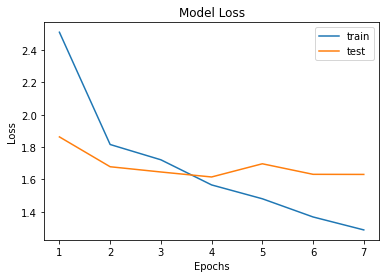

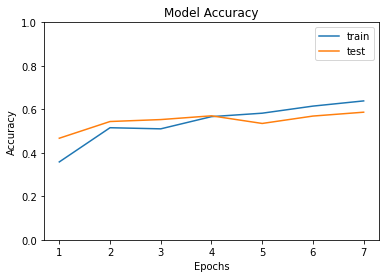

In [28]:
# Plot the Model loss
plt.plot([x+1 for x in range(epochs)], history.history['loss'])
plt.plot([x+1 for x in range(epochs)], history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot([x+1 for x in range(epochs)], history.history['accuracy'])
plt.plot([x+1 for x in range(epochs)], history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()

### Part d) More Advanced RNN Model (15 points)
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss and your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [29]:
# Build your model

input = Input(shape=(max_seq))
x = Embedding(vocab_len, 150)(input)

x = LSTM(40)(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.55)(x)
x = Dense(90, activation='relu')(x)

x = Dense(46, activation='softmax')(x)
reuters_model = Model(input, x)

loss = 'categorical_crossentropy'

opt = tf.keras.optimizers.Adam(0.0029)

metrics = ['accuracy']

reuters_model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics)

reuters_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1500)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 1500, 150)         4647450   
                                                                 
 lstm_2 (LSTM)               (None, 40)                30560     
                                                                 
 dense_5 (Dense)             (None, 200)               8200      
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 90)                18090     
                                                                 
 dense_7 (Dense)             (None, 46)                4186

In [30]:
batchsize = 40
epochs =  8

# Fit model
history = reuters_model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_split=0.2, shuffle=True)

Epoch 1/8
180/180 [==============================] - 32s 164ms/step - loss: 2.1489 - accuracy: 0.4407 - val_loss: 1.7136 - val_accuracy: 0.5356
Epoch 2/8
180/180 [==============================] - 29s 161ms/step - loss: 1.6686 - accuracy: 0.5548 - val_loss: 1.5693 - val_accuracy: 0.5846
Epoch 3/8
180/180 [==============================] - 29s 161ms/step - loss: 1.4264 - accuracy: 0.6217 - val_loss: 1.5812 - val_accuracy: 0.6024
Epoch 4/8
180/180 [==============================] - 29s 161ms/step - loss: 1.2122 - accuracy: 0.6790 - val_loss: 1.5536 - val_accuracy: 0.6320
Epoch 5/8
180/180 [==============================] - 29s 160ms/step - loss: 1.0233 - accuracy: 0.7229 - val_loss: 1.6193 - val_accuracy: 0.6570
Epoch 6/8
180/180 [==============================] - 29s 161ms/step - loss: 0.8669 - accuracy: 0.7586 - val_loss: 1.5638 - val_accuracy: 0.6581
Epoch 7/8
180/180 [==============================] - 29s 161ms/step - loss: 0.7323 - accuracy: 0.7961 - val_loss: 1.5755 - val_accuracy:

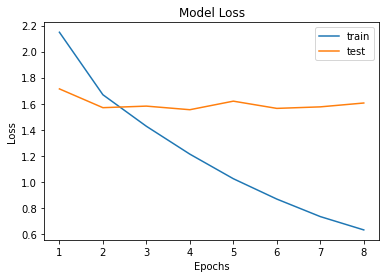

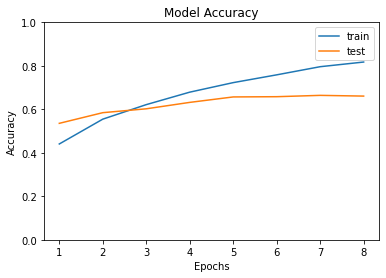

In [31]:
# Plot the Model loss
plt.plot([x+1 for x in range(epochs)], history.history['loss'])
plt.plot([x+1 for x in range(epochs)], history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot([x+1 for x in range(epochs)], history.history['accuracy'])
plt.plot([x+1 for x in range(epochs)], history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.ylim([0,1])
plt.show()

### Part e) Looking at the Predictions (10 points)

Now, Using the final (best) model you trained, show your model's performance on the test set.
Calculate and display the prediction accuracy for all of the 46 different classes. 

In [32]:
num_classes = 46
performance = reuters_model.evaluate(X_test, y_test)

prediction = reuters_model.predict(X_test)
classifications = np.array([np.argmax(i) for i in prediction])
print(f"Prediction Accuracy: {accuracy_score(classifications, y_labels)}")

71/71 [==============================] - 5s 74ms/step - loss: 1.7020 - accuracy: 0.6509
Prediction Accuracy: 0.6509349955476402


Label: 0 Accuracy: 0.0
Label: 1 Accuracy: 0.7102803738317757
Label: 2 Accuracy: 0.0
Label: 3 Accuracy: 0.8930817610062893
Label: 4 Accuracy: 0.797938144329897
Label: 5 Accuracy: 0.0
Label: 6 Accuracy: 0.0
Label: 7 Accuracy: 0.0
Label: 8 Accuracy: 0.2777777777777778
Label: 9 Accuracy: 0.12
Label: 10 Accuracy: 0.5161290322580645
Label: 11 Accuracy: 0.5052631578947369
Label: 12 Accuracy: 0.0
Label: 13 Accuracy: 0.38095238095238093
Label: 14 Accuracy: 0.0
Label: 15 Accuracy: 0.0
Label: 16 Accuracy: 0.3669724770642202
Label: 17 Accuracy: 0.0
Label: 18 Accuracy: 0.17647058823529413
Label: 19 Accuracy: 0.5328467153284672
Label: 20 Accuracy: 0.4852941176470588
Label: 21 Accuracy: 0.34615384615384615
Label: 22 Accuracy: 0.0
Label: 23 Accuracy: 0.09090909090909091
Label: 24 Accuracy: 0.3125
Label: 25 Accuracy: 0.8
Label: 26 Accuracy: 0.0
Label: 27 Accuracy: 0.0
Label: 28 Accuracy: 0.25
Label: 29 Accuracy: 0.0
Label: 30 Accuracy: 0.0
Label: 31 Accuracy: 0.2
Label: 32 Accuracy: 0.0
Label: 33 Accur

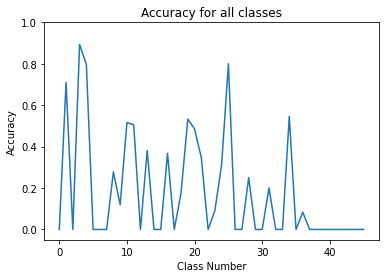

In [33]:
total_correct = np.array([0] * num_classes)
counts = np.bincount(y_labels)

for i, label in enumerate(y_labels):
  if classifications[i] == label:
    total_correct[label]+=1

accuracies = np.divide(total_correct, counts)

for i, acc in enumerate(accuracies):
  print(f"Label: {i} Accuracy: {acc}")

plt.plot([x for x in range(num_classes)], accuracies)
plt.title('Accuracy for all classes')
plt.ylabel('Accuracy')
plt.xlabel('Class Number')
plt.ylim([-0.05,1])
plt.show()

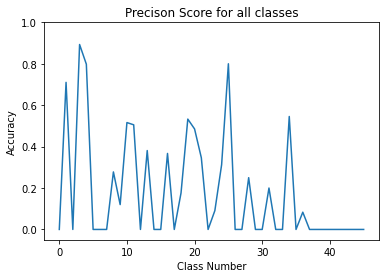

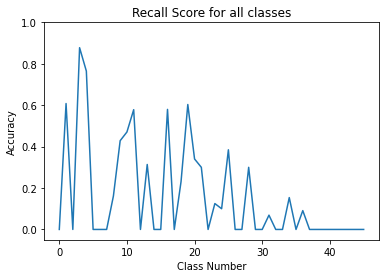

In [34]:
ps = precision_score(classifications, y_labels, average=None)
rs = recall_score(classifications, y_labels, zero_division=0, average=None)

plt.plot([x for x in range(num_classes)], ps)
plt.title('Precison Score for all classes')
plt.ylabel('Accuracy')
plt.xlabel('Class Number')
plt.ylim([-0.05,1])
plt.show()

plt.plot([x for x in range(num_classes)], rs)
plt.title('Recall Score for all classes')
plt.ylabel('Accuracy')
plt.xlabel('Class Number')
plt.ylim([-0.05,1])
plt.show()